### Load packages

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

### Import ZLP data

In [132]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat



 ***************************************************** 



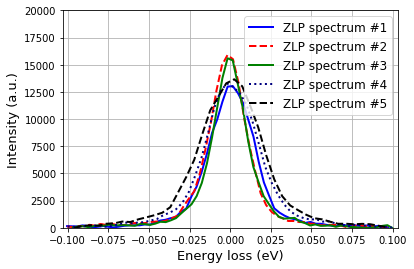

In [133]:
%run EELS-ZLP.py

## Neural Network

### Build architecture

In [254]:
inputsize = len(EELSData_intensity_zlp_1)
outputsize = inputsize

model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(inputsize,1)),
    keras.layers.Dense(inputsize, activation='relu'),
    keras.layers.Dense(outputsize)
])

model.compile(loss='mean_squared_error',
              optimizer='sgd')




## Prepare trainings data 

In [260]:
y_train = EELSData_intensity_zlp_1
x_train = EELSData_Eloss_1
N_train = 10000

vector = np.ones(N_train)
x_train =  np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * x_train), 1, 2)
y_train = np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * y_train), 1, 2)

### Normalization
y_max = np.max(y_train, axis=1)
y_train_norm = np.divide(y_train, y_max[:, None, :])
y_train_norm = np.squeeze(y_train_norm, axis=2)

### Show sample of training data

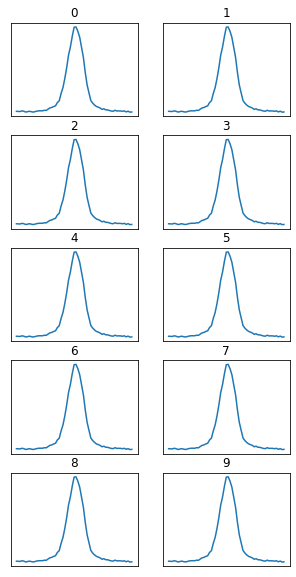

In [261]:
plt.figure(figsize=(5,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(x_train[i], y_train_norm[i])
    plt.title(i)
plt.show()

In [265]:
model.fit(x_train, y_train_norm, batch_size = 5, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 2s 172us/sample - loss: 1.0706e-10
Epoch 2/10
10000/10000 [==============================] - 2s 164us/sample - loss: 9.6253e-11
Epoch 3/10
10000/10000 [==============================] - 2s 164us/sample - loss: 8.8304e-11
Epoch 4/10
10000/10000 [==============================] - 2s 164us/sample - loss: 8.1981e-11
Epoch 5/10
10000/10000 [==============================] - 2s 164us/sample - loss: 7.6798e-11
Epoch 6/10
10000/10000 [==============================] - 2s 164us/sample - loss: 7.2268e-11
Epoch 7/10
10000/10000 [==============================] - 2s 165us/sample - loss: 6.8583e-11
Epoch 8/10
10000/10000 [==============================] - 2s 163us/sample - loss: 6.5364e-11
Epoch 9/10
10000/10000 [==============================] - 2s 164us/sample - loss: 6.2585e-11
Epoch 10/10
10000/10000 [==============================] - 2s 164us/sample - loss: 6.0282e-11
